In [ ]:
import torch
import torch.nn as nn
from torchtext import data
from torchtext import datasets
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords = set(stopwords.words("english"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
inputs = data.Field(lower=True, tokenize='spacy', stop_words=stopwords, batch_first=True)
answers = data.LabelField(dtype = torch.long, batch_first=True)

train, dev, test = datasets.SNLI.splits(inputs, answers, root='.dataset')

inputs.build_vocab(train)
answers.build_vocab(test)

train_iter, dev_iter, test_iter = data.BucketIterator.splits(   
    (train, dev, test), batch_size=256, device=device)

# z = 0
# for batch in train_iter:
#     z+=1
#     print(batch.hypothesis.shape)
#     print(batch.hypothesis)
#     print()
#     if z == 2:
#         break


# iter = data.BucketIterator(datasets.SNLI, batch_size=128, shuffle=True)
# test_iter = iter.splits(train, batch_size=128, device=device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import torch
import torch.nn as nn


class LstmModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim)

        self.lstm = nn.LSTM(emb_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout,
                            batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 4, 512),
            nn.LeakyReLU(negative_slope=0.05),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope=0.05),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope=0.05),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.05),
            nn.Dropout(),
            nn.Linear(256, output_dim)
        )
        self.act = nn.Softmax(dim=1)


    def apply_attention(self, rnn_output, final_hidden_state):
        '''
        Apply Attention on RNN output
        
        Input:
            rnn_output (batch_size, seq_len, num_directions * hidden_size): tensor representing hidden state for every word in the sentence
            final_hidden_state (batch_size, num_directions * hidden_size): final hidden state of the RNN
            
        Returns:
            attention_output(batch_size, num_directions * hidden_size): attention output vector for the batch
        '''
        # print(rnn_output.shape)
        # print(hidden_state.shape)
        hidden_state = final_hidden_state.unsqueeze(2)
        attention_scores = torch.bmm(rnn_output, hidden_state).squeeze(2)
        soft_attention_weights = F.softmax(attention_scores, 1).unsqueeze(2) #shape = (batch_size, seq_len, 1)
        attention_output = torch.bmm(rnn_output.permute(0,2,1), soft_attention_weights).squeeze(2)
        return attention_output



    def forward(self, batch):
        # text1 = torch.transpose(batch.hypothesis[0], 0, 1).to(device)
        # text2 = torch.transpose(batch.premise[0], 0, 1).to(device)
        text1 = batch.hypothesis
        text2 = batch.premise
        embedded1 = self.embedding(text1)
        embedded2 = self.embedding(text2)
        op1, (hidden1, cell) = self.lstm(embedded1)
        op2, (hidden2, cell) = self.lstm(embedded2)
        hidden_feature1 = torch.cat((hidden1[-1, :, :], hidden1[-2, :, :]), dim=1)
        hidden_feature2 = torch.cat((hidden2[-1, :, :], hidden2[-2, :, :]), dim=1)
        att1 = self.apply_attention(op1, hidden_feature1)
        att2 = self.apply_attention(op2, hidden_feature2)
        hidden = torch.cat((att1, att2), dim=1)
        
        # hidden = torch.cat((hidden1[-1, :, :], hidden2[-1, :, :]), dim=1)
        dense_outputs = self.fc(hidden)
        outputs = self.act(dense_outputs)
        return outputs


In [ ]:
model = LstmModel(len(inputs.vocab), 200, 128, 3, 3, True, 0)
model = model.to(device)
# pretrained_embeds = inputs.vocab.vectors
# model.embedding.weight.data.copy_(pretrained_embeds, non_blocking=False)
# print(pretrained_embeds.shape)



In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.00055)

def compute_accuracy(preds, y):
    correct = (torch.argmax(preds, dim=1) == y).float()
    accuracy = correct.sum()/len(correct)
    return accuracy
    


In [ ]:
import torch.nn.functional as F

def train_LSTM_model(model, iterator, optimizer):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in iterator:
        optimizer.zero_grad()
        # text = torch.cat((batch.hypothesis[0], batch.premise[0]), dim=0)
        # text = torch.transpose(text, 0, 1).to(device)
        # text_lengths = torch.cat((batch.hypothesis[1], batch.premise[1]), dim=0)
        pred = model(batch).squeeze()
        loss = F.cross_entropy(pred, batch.label)
        acc = compute_accuracy(pred, batch.label)
        loss.backward()  
        optimizer.step()
        epoch_loss += loss.item()  
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def test_LSTM_model(model, iterator):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            # text = torch.cat((batch.hypothesis[0], batch.premise[0]), dim=0)
            # text = torch.transpose(text, 0, 1).to(device)
            # text_lengths = torch.cat((batch.hypothesis[1], batch.premise[1]), dim=0)
            pred = model(batch).squeeze()
            loss = F.cross_entropy(pred, batch.label)
            acc = compute_accuracy(pred, batch.label)
            epoch_loss += loss.item()  
            epoch_acc += acc.item()            

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
num_epochs = 30
best_valid_loss = float('inf')
torch.manual_seed(0)
torch.cuda.manual_seed(0)
loss_arr = []
acc_arr = []

for ep in range(num_epochs):
    train_loss, train_acc = train_LSTM_model(model, train_iter, optimizer)
    print("train loss and accuracy after ", ep, "iterations : ", train_loss, train_acc)
    loss_arr.append(train_loss)
    
    valid_loss, valid_acc = test_LSTM_model(model, test_iter)
    print("test loss and accuracy after ", ep, "iterations : ", valid_loss, valid_acc)
    acc_arr.append(valid_acc)
    print()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), 'saved_weights4.pt')
        for g in optimizer.param_groups:
            g['lr'] *= 1.1
    else:
        for g in optimizer.param_groups:
            g['lr'] *= 0.8






train loss and accuracy after  0 iterations :  0.9321154518485181 0.5951673312656033
test loss and accuracy after  0 iterations :  0.8828066480465424 0.6573851505915324

train loss and accuracy after  1 iterations :  0.8563191144964124 0.6828517082797403
test loss and accuracy after  1 iterations :  0.8536087687198932 0.6839610047829456

train loss and accuracy after  2 iterations :  0.828651819819062 0.7132020419930478
test loss and accuracy after  2 iterations :  0.8451120578325712 0.6969484518735837

train loss and accuracy after  3 iterations :  0.8106453236806982 0.7327305137388971
test loss and accuracy after  3 iterations :  0.8414207544082251 0.7016559839248657

train loss and accuracy after  4 iterations :  0.7962500408833425 0.7483314525714458
test loss and accuracy after  4 iterations :  0.8381359149248172 0.7051282051282052

train loss and accuracy after  5 iterations :  0.7845562909211605 0.7611692270328259
test loss and accuracy after  5 iterations :  0.8339814375608395 0

KeyboardInterrupt: ignored

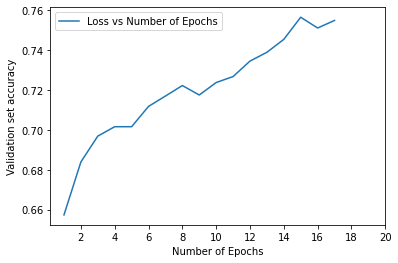

In [ ]:
import matplotlib.pylab as pylab
import numpy as np

def plot_loss(ep, loss_arr):
    
    epoch_arr = list(range(1, ep + 1))

    # pylab.scatter(epoch_arr, loss_arr)
    pylab.plot(epoch_arr, loss_arr, label = 'Loss vs Number of Epochs')

    # tick_arr = np.arange(1, ep + 1, 5).tolist()
    tick_arr = [2,4,6,8,10,12,14,16,18,20]
    pylab.xticks(tick_arr)
    # pylab.yscale("log")
    pylab.legend(loc='upper left')
    pylab.xlabel("Number of Epochs")
    pylab.ylabel("Validation set accuracy")
    pylab.savefig('plot_lstm.pdf')

    pylab.show()

    return

ep = 17
# l = []
# for k in loss_arr:
#     l.append(k.item())
acc_arr = [0.6573851505915324, 0.6839610047829456, 0.6969484518735837, 0.7016559839248657, 0.7016559839248657, 0.7118389423076923, 0.7170472756410257, 0.7223223829880739, 0.7175814646940964, 0.7238247868342277, 0.7268295945265354, .7346, .739, .7455, .7566, .7512, .755]
plot_loss(ep, acc_arr)


In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

path='/content/saved_weights3.pt'
test_model = LstmModel(len(inputs.vocab), 200, 128, 3, 2, True, 0)
test_model.load_state_dict(torch.load(path))

valid_loss, valid_acc = test_LSTM_model(model, test_iter)
print("test loss and accuracy after ", ep, "iterations : ", valid_loss, valid_acc)


test loss and accuracy after  25 iterations :  0.7832937588939419 0.7656926412086982
